<a href="https://colab.research.google.com/github/xelav/boosters-digital-reputation/blob/master/Boosters_experiments_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
""
root_dir = "/content/drive/My Drive/boosters"
%cd "{root_dir}"
!pip install catboost

Mounted at /content/drive
/content/drive/My Drive/boosters


# Prapare data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.ensemble import VotingClassifier

from tqdm import tqdm
from catboost import CatBoostClassifier

import datetime
import json
import pickle
import copy

from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import cv as catboost_cv
from scipy import sparse

import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import lightgbm as lgb

In [0]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

In [0]:
def get_x2_summed(X2):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    return np.squeeze(np.asarray(sparse_matrix.sum(axis=1)))

# X1['X2_summed'] = get_x2_summed(X2)
# X1_test['X2_summed'] = get_x2_summed(X2_test)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


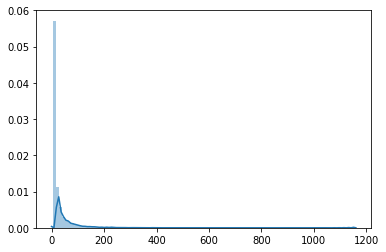

In [0]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    
    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, np.squeeze(np.asarray(selected_cols))]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    X2_summed = np.squeeze(np.asarray(sparse_matrix.sum(axis=1)))
    return X2, X2_summed, svd

X2_all = X2.append(X2_test)
X2_all, X2_summed, svd = transform_x2(X2_all)

X2_tranformed = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X2, on='id', how='inner').merge(X3, on='id').merge(Y, on='id')
X = df.iloc[:, :-5]
X = X.drop('id', axis=1)
Y_cls = df.iloc[:, -5:]

X2_tranformed_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test, on='id')
X_submit = df_test

In [0]:
def validate(estimator, X_train, y_train, random_state=None, n_folds=5):

    cv = KFold(n_splits=n_folds, shuffle=False, random_state=random_state)
    cv_iter = list(cv.split(X_train, y_train))

    scores=[]
    for train, test in tqdm(cv_iter):
        estimator.fit(X_train[train, :], y_train[train],
                        # eval_set=(X_train[test, :], y_train[test])
                        )
        pred_statement = estimator.predict_proba(X_train[test, :])[:, 1]
        metric = roc_auc_score(y_train[test], pred_statement)
        print(metric)
        scores.append(metric)
    return np.array(scores)

In [0]:
def make_predictions(estimator, exp_name, X_train, Y_train, X_test):
    probas = []

    for i in tqdm('12345'):

        # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
        y = Y_train[i].values

        estimator.fit(X_train, y)
        proba = estimator.predict_proba(X_test)[:, 1]

        probas.append(proba)

    tmp = pd.DataFrame(probas).T
    baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
    baseline['id'] = X1_test['id']
    baseline[['id', '1', '2', '3', '4', '5']].to_csv(exp_name+'.csv', index=False)

## Simple catboost

In [0]:
params = {}
params['n_estimators'] = 1000
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

results = cross_validation_score_statement(clf, X, Y['1'], scoring=roc_auc_score)
print(results)
print(results.mean())

0:	learn: 0.4997743	test: 0.5000000	best: 0.5000000 (0)	total: 39.9ms	remaining: 39.8s
100:	learn: 0.6143574	test: 0.5789550	best: 0.5796110 (88)	total: 3.89s	remaining: 34.6s
200:	learn: 0.6195948	test: 0.5782380	best: 0.5796110 (88)	total: 7.83s	remaining: 31.1s
300:	learn: 0.6206247	test: 0.5783181	best: 0.5806369 (266)	total: 11.9s	remaining: 27.6s
400:	learn: 0.6226978	test: 0.5781922	best: 0.5806369 (266)	total: 15.8s	remaining: 23.6s
500:	learn: 0.6229277	test: 0.5787147	best: 0.5806369 (266)	total: 19.7s	remaining: 19.6s
600:	learn: 0.6235341	test: 0.5804806	best: 0.5807933 (586)	total: 23.5s	remaining: 15.6s
700:	learn: 0.6230668	test: 0.5818993	best: 0.5823036 (689)	total: 27.4s	remaining: 11.7s
800:	learn: 0.6232650	test: 0.5812624	best: 0.5823036 (689)	total: 31.3s	remaining: 7.77s
900:	learn: 0.6232187	test: 0.5821739	best: 0.5823036 (689)	total: 35.2s	remaining: 3.87s
999:	learn: 0.6232911	test: 0.5823570	best: 0.5829367 (974)	total: 39s	remaining: 0us
bestTest = 0.582936

## Leave only important features experiment

In [0]:
clf = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

clf.fit(X.values, Y['1'].values)

fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': cols})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]

0:	learn: 0.5000525	total: 40.1ms	remaining: 40.1s
100:	learn: 0.6099467	total: 3.9s	remaining: 34.8s
200:	learn: 0.6114708	total: 7.71s	remaining: 30.7s
300:	learn: 0.6125335	total: 11.5s	remaining: 26.7s
400:	learn: 0.6129431	total: 15.3s	remaining: 22.8s
500:	learn: 0.6132775	total: 18.9s	remaining: 18.8s
600:	learn: 0.6124242	total: 22.6s	remaining: 15s
700:	learn: 0.6126498	total: 26.3s	remaining: 11.2s
800:	learn: 0.6124891	total: 30s	remaining: 7.46s
900:	learn: 0.6126898	total: 33.7s	remaining: 3.71s
999:	learn: 0.6125666	total: 37.4s	remaining: 0us


NameError: ignored

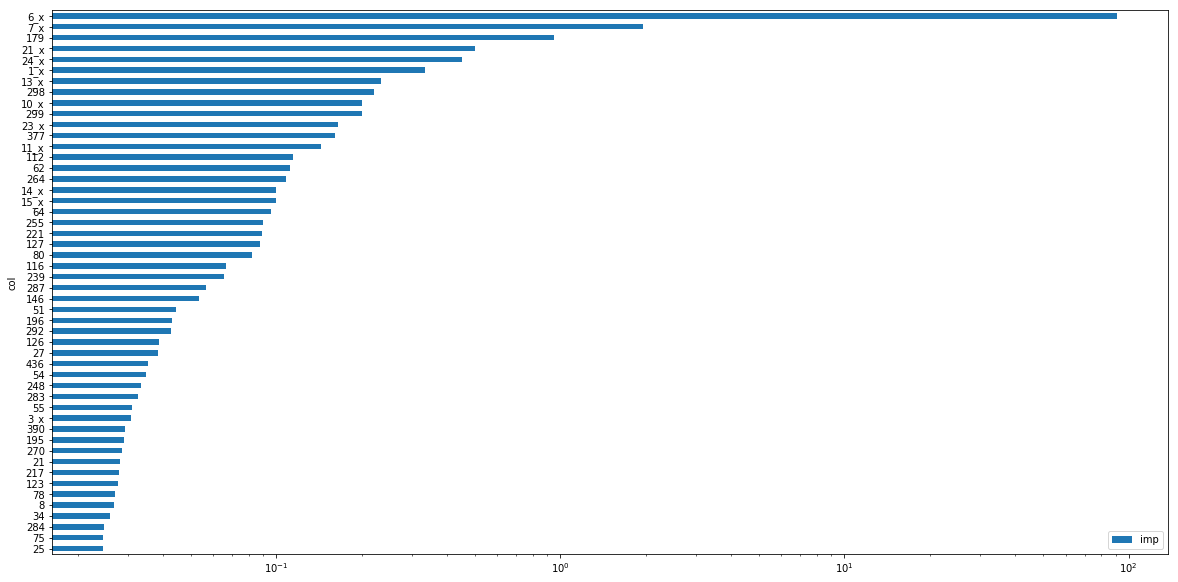

In [0]:
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-50:]
ax = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
ax.set_xscale('log')

In [0]:
params = {}
params['n_estimators'] = 1000
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

results = cross_validation_score_statement(clf, X_important, Y['1'], scoring=roc_auc_score)
print(results)
print(results.mean())

In [0]:
X_submit_imp = X_submit[fea_imp[fea_imp['imp'] > 0.001].col]

In [0]:
probas = []
scores = []
for i in tqdm('12345'):
    clf = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)
    clf.fit(X_important.values, Y[i].values)
    proba = clf.predict_proba(X_submit_imp.values)[:, 1]
    probas += [proba]

filename = '{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_submit['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, index=False)



  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5025740	total: 36ms	remaining: 35.9s
100:	learn: 0.6111721	total: 3.58s	remaining: 31.9s
200:	learn: 0.6113486	total: 7.12s	remaining: 28.3s
300:	learn: 0.6117551	total: 10.6s	remaining: 24.7s
400:	learn: 0.6117372	total: 14.2s	remaining: 21.1s
500:	learn: 0.6111163	total: 17.7s	remaining: 17.6s
600:	learn: 0.6107603	total: 21.2s	remaining: 14.1s
700:	learn: 0.6108807	total: 24.8s	remaining: 10.6s
800:	learn: 0.6114823	total: 28.5s	remaining: 7.08s
900:	learn: 0.6118979	total: 32.1s	remaining: 3.53s
999:	learn: 0.6119606	total: 35.6s	remaining: 0us




 20%|██        | 1/5 [00:37<02:29, 37.44s/it]

0:	learn: 0.5095196	total: 29.9ms	remaining: 29.9s
100:	learn: 0.5830205	total: 2.99s	remaining: 26.6s
200:	learn: 0.5819819	total: 6.27s	remaining: 24.9s
300:	learn: 0.5832503	total: 9.81s	remaining: 22.8s
400:	learn: 0.5850928	total: 13.3s	remaining: 19.9s
500:	learn: 0.5843042	total: 16.9s	remaining: 16.8s
600:	learn: 0.5837253	total: 20.4s	remaining: 13.5s
700:	learn: 0.5848657	total: 23.9s	remaining: 10.2s
800:	learn: 0.5862822	total: 27.5s	remaining: 6.83s
900:	learn: 0.5873440	total: 31s	remaining: 3.41s
999:	learn: 0.5879870	total: 34.5s	remaining: 0us




 40%|████      | 2/5 [01:13<01:51, 37.10s/it]

0:	learn: 0.6020982	total: 32.5ms	remaining: 32.4s
100:	learn: 0.6328336	total: 2.96s	remaining: 26.3s
200:	learn: 0.6361703	total: 5.91s	remaining: 23.5s
300:	learn: 0.6378378	total: 8.82s	remaining: 20.5s
400:	learn: 0.6403879	total: 11.7s	remaining: 17.5s
500:	learn: 0.6427887	total: 14.6s	remaining: 14.6s
600:	learn: 0.6438600	total: 17.6s	remaining: 11.7s
700:	learn: 0.6442480	total: 20.7s	remaining: 8.82s
800:	learn: 0.6445465	total: 24.1s	remaining: 6s
900:	learn: 0.6445772	total: 27.7s	remaining: 3.04s
999:	learn: 0.6444422	total: 31.2s	remaining: 0us




 60%|██████    | 3/5 [01:46<01:11, 35.87s/it]

0:	learn: 0.4998935	total: 29.9ms	remaining: 29.9s
100:	learn: 0.6188008	total: 2.95s	remaining: 26.2s
200:	learn: 0.6189544	total: 5.85s	remaining: 23.3s
300:	learn: 0.6213424	total: 8.77s	remaining: 20.4s
400:	learn: 0.6230479	total: 11.7s	remaining: 17.5s
500:	learn: 0.6229301	total: 14.6s	remaining: 14.5s
600:	learn: 0.6230899	total: 17.5s	remaining: 11.6s
700:	learn: 0.6222225	total: 20.4s	remaining: 8.72s
800:	learn: 0.6228997	total: 23.3s	remaining: 5.8s
900:	learn: 0.6233216	total: 26.4s	remaining: 2.9s
999:	learn: 0.6228049	total: 29.5s	remaining: 0us




 80%|████████  | 4/5 [02:17<00:34, 34.46s/it]

0:	learn: 0.5002739	total: 32.6ms	remaining: 32.6s
100:	learn: 0.5800228	total: 3.15s	remaining: 28.1s
200:	learn: 0.5785971	total: 6.19s	remaining: 24.6s
300:	learn: 0.5808976	total: 9.53s	remaining: 22.1s
400:	learn: 0.5799211	total: 13s	remaining: 19.4s
500:	learn: 0.5819254	total: 16.4s	remaining: 16.3s
600:	learn: 0.5822128	total: 19.8s	remaining: 13.2s
700:	learn: 0.5814606	total: 23.3s	remaining: 9.94s
800:	learn: 0.5816871	total: 26.8s	remaining: 6.65s
900:	learn: 0.5818675	total: 30.2s	remaining: 3.32s
999:	learn: 0.5831054	total: 33.7s	remaining: 0us




100%|██████████| 5/5 [02:53<00:00, 34.78s/it]



**0.570 LB**


## Cat+XGB+LGB Voting experiment

In [0]:
import xgboost as xgb

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=200, max_depth=1, learning_rate=0.1)

In [0]:
X_train = X.values
y_train = Y['1'].values

scores = validate(xgb_cls, X_train, y_train)
print(scores)
print(scores.mean())

scores = validate(clf_cat, X_train, y_train)
print(scores)
print(scores.mean())

scores = validate(lgb_model, X_train, y_train)
print(scores)
print(scores.mean())

[0.58390542 0.61686714 0.59216581 0.59421494 0.62029292]
0.6014892462750935
[0.59080473 0.61602155 0.58869025 0.60370255 0.60463444]
0.6007707050293948
[0.57407323 0.58787548 0.6024769  0.59898404 0.59264477]
0.5912108831928927


In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    X_train = X.values
    y_train = Y[i].values

    eclf.fit(X_train, y_train)

    proba = eclf.predict_proba(X_submit.drop('id', axis=1).values)[:, 1]
    probas.append(proba)

100%|██████████| 5/5 [00:38<00:00,  7.77s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble-simpleX.csv', index=False)

!0.565254

## Cat+XGB+LGB Voting experiment with X1-only


In [0]:
import xgboost as xgb

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=200, max_depth=1, learning_rate=0.1)

In [0]:
X_train = X1.drop('id', axis=1).values
y_train = Y['1'].values

scores = validate(xgb_cls, X_train, y_train)
print(scores)
print(scores.mean())

scores = validate(clf_cat, X_train, y_train)
print(scores)
print(scores.mean())

scores = validate(lgb_model, X_train, y_train)
print(scores)
print(scores.mean())

[0.58755912 0.62303153 0.57914737 0.61378269 0.61531801]
0.6037677432360888
[0.58847826 0.62220424 0.58441292 0.59909604 0.59476167]
0.5977906280065769
[0.57540427 0.60995234 0.57972539 0.61094652 0.61721112]
0.5986479271685626


In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    X_train = X1.drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train, y_train)

    proba = eclf.predict_proba(X1_test.drop('id', axis=1).values)[:, 1]
    probas.append(proba)

100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble-X1-only.csv', index=False)

!0.586625

## Cat+XGB+LGB Voting experiment with X1+sum(X2)

In [0]:
import xgboost as xgb

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
def validate(estimator, X_train, y_train, random_state=1234):

    cv = KFold(n_splits=5, shuffle=False, random_state=random_state)
    cv_iter = list(cv.split(X_train, y_train))

    scores=[]
    for train, test in cv_iter:
        estimator.fit(X_train[train, :], y_train[train],
                        # eval_set=(X_train[test, :], y_train[test])
                        )
        pred_statement = estimator.predict_proba(X_train[test, :])[:, 1]
        scores.append(roc_auc_score(y_train[test], pred_statement))
    return np.array(scores)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=200, max_depth=1, learning_rate=0.1)

In [0]:
X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
y_train = Y['1'].values

scores = validate(xgb_cls, X_train, y_train)
print(scores)
print(scores.mean())

scores = validate(clf_cat, X_train, y_train)
print(scores)
print(scores.mean())

scores = validate(lgb_model, X_train, y_train)
print(scores)
print(scores.mean())

[0.59012967 0.62424684 0.58105669 0.60411082 0.61570691]
0.603050184837935
[0.58583905 0.62379659 0.58577033 0.60067129 0.59720877]
0.5986572059516483
[0.57528604 0.61189976 0.58106788 0.60266202 0.61741657]
0.597666454462956


In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train, y_train)

    proba = eclf.predict_proba(X1_test.drop('id', axis=1).values)[:, 1]
    probas.append(proba)

100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble.csv', index=False)

!0.5866250
FUCK YEAH

## Cat+XGB+LGB Voting experiment with X1+sum(X2)+X3

In [0]:
import xgboost as xgb

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=200, max_depth=1, learning_rate=0.1)

In [0]:
X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .merge(X3, on='id', suffixes=('_x1', '_x3'))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5].drop('id', axis=1)

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .merge(X3_test, on='id', suffixes=('_x1', '_x3'))\
    .drop('id', axis=1)

y_train = Y['1']

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
scores = validate(xgb_cls, X_train.values, y_train.values)
print(scores)
print(scores.mean())

scores = validate(clf_cat, X_train.values, y_train.values)
print(scores)
print(scores.mean())

scores = validate(lgb_model, X_train.values, y_train.values)
print(scores)
print(scores.mean())

[0.5735164  0.60684818 0.58067259 0.58405532 0.6087325 ]
0.5907649982676182
[0.58675439 0.61954668 0.58195541 0.60085916 0.59921194]
0.5976655151683923
[0.57855454 0.57434238 0.58109771 0.57353441 0.58994453]
0.5794947126239628


In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train.values, y_train)

    proba = eclf.predict_proba(X_test.values)[:, 1]
    probas.append(proba)

100%|██████████| 5/5 [00:31<00:00,  6.24s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble-X1-X2_sum-X3.csv', index=False)

## Ensemble with X1+Sum(X2)+Sum(X3)

In [0]:
import xgboost as xgb

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)

scores = validate(lgb_model, X_train.values, y_train.values)
print(scores)
print(scores.mean())

NameError: ignored

In [0]:
X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed=X3.sum(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5].drop('id', axis=1)

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed=X3_test.sum(axis=1))\
    .drop('id', axis=1)

y_train = Y['1']


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
scores = validate(xgb_cls, X_train.values, y_train.values)
print(scores)
print(scores.mean())

scores = validate(clf_cat, X_train.values, y_train.values)
print(scores)
print(scores.mean())

scores = validate(lgb_model, X_train.values, y_train.values)
print(scores)
print(scores.mean())

[0.59060259 0.62892138 0.57963216 0.60353636 0.61755599]
0.604049694437027
[0.58834096 0.62172471 0.58471498 0.59949346 0.594182  ]
0.5976912240045544
[0.578627   0.61377397 0.58417426 0.60537535 0.61924364]
0.600238842628108


In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train.values, y_train)

    proba = eclf.predict_proba(X_test.values)[:, 1]
    probas.append(proba)


100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble-X1-X2_sum-X3_sum.csv', index=False)

!0.5890010

In [0]:
import xgboost as xgb

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        # 'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)

In [0]:
X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed=X3.drop('id',axis=1).sum(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed=X3_test.drop('id',axis=1).sum(axis=1))

y_train = Y['1']


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
scores = validate(xgb_cls, X_train.values, y_train.values)
print(scores)
print(scores.mean())

scores = validate(clf_cat, X_train.values, y_train.values)
print(scores)
print(scores.mean())

scores = validate(lgb_model, X_train.values, y_train.values)
print(scores)
print(scores.mean())

[0.58675439 0.62395765 0.578409   0.60113013 0.61470165]
0.6009905643951253
[0.58864989 0.62222255 0.58470379 0.59935617 0.5946296 ]
0.5979123992488846
[0.59695652 0.61302355 0.58714265 0.60240912 0.61612515]
0.603131399025565


In [0]:
# forest_clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)

In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

In [0]:
scores = validate(eclf, X_train.values, y_train.values)
print(scores)
print(scores.mean())

[0.59363844 0.63150574 0.58466277 0.60609071 0.61953714]
0.6070869620989028


In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)

scores = validate(clf, X_train.values, y_train.values)
print(scores)
print(scores.mean())

[0.56485889 0.60174902 0.57837544 0.57802892 0.57840612]
0.5802836758874135


In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train.values, y_train)
    proba = eclf.predict_proba(X_test.values)[:, 1]
    probas.append(proba)

100%|██████████| 5/5 [00:30<00:00,  6.19s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble_forest-X1-X2_sum-with_id.csv', index=False)

In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train.values, y_train)
    proba = eclf.predict_proba(X_test.values)[:, 1]
    for j in range(9):
        eclf.fit(X_train.values, y_train)
        proba += eclf.predict_proba(X_test.values)[:, 1]

    proba /= 10
    probas.append(proba)

100%|██████████| 5/5 [05:00<00:00, 60.13s/it]


In [0]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble_forest-X1-X2_sum-with_id-averaged.csv', index=False)

In [0]:
X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 > 0.00001].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test > 0.00001].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)

y_train = Y['1']


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train.values, y_train)
    proba = eclf.predict_proba(X_test.values)[:, 1]

    probas.append(proba)

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble_forest-X1-X2_sum-with_id-X3_denorm_sum.csv', index=False)

100%|██████████| 5/5 [00:32<00:00,  6.39s/it]


In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')
scores = validate(eclf, X_train.values, y_train.values)
print(scores)
print(scores.mean())

[0.59448513 0.61982854 0.58968966 0.60994212 0.60373558]
0.6035362055480483


In [0]:
from sklearn.ensemble import BaggingClassifier
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')
bagging_clf = BaggingClassifier(eclf, max_samples=0.5, max_features=0.5)

y_train = Y['1']

scores = validate(bagging_clf, X_train.values, y_train.values)
print(scores)
print(scores.mean())

100%|██████████| 5/5 [04:45<00:00, 57.04s/it]

[0.56918383 0.62273503 0.59405276 0.59111503 0.57155646]
0.5897286200674499


In [0]:
X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 > 0.00001].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test > 0.00001].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)\
    .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\

y_train = Y['1']

probas = []

for i in tqdm('12345'):
    eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')
    bagging_clf = BaggingClassifier(eclf, max_samples=0.5, max_features=0.5)

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y_train = Y[i].values

    eclf.fit(X_train.values, y_train)
    proba = eclf.predict_proba(X_test.values)[:, 1]

    probas.append(proba)

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('ensemble_forest-X1-X2_sum-with_id-X3-sum-mean-non_zero.csv', index=False)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 5/5 [00:30<00:00,  6.06s/it]


## Test with decrease X2 reduction

In [0]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)

    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, np.squeeze(np.asarray(selected_cols))]

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    return X2, svd

In [0]:
def X2_to_sparse(X2):

    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)

    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, np.squeeze(np.asarray(selected_cols))]

    return trimmed_sparse_matrix

In [0]:
np.array(trimmed_sparse_matrix),

(array(<4000x15769 sparse matrix of type '<class 'numpy.float64'>'
 	with 303940 stored elements in Compressed Sparse Row format>,
       dtype=object),)

In [0]:


lda = LinearDiscriminantAnalysis(n_components=100)
lda.fit(trimmed_sparse_matrix.toarray(), Y['1'])

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(15769, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=100, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [0]:
X2_lda = lda.transform(trimmed_sparse_matrix.toarray())
X2_lda.shape

In [0]:
X_train = X1\
    .assign(X2_lda=X2_lda)\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

# X_test = X1_test\
#     .assign(X2_summed=get_x2_summed(X2_test))\
#     .assign(X3_summed_dernomalized=X3_test_summed)

y_train = Y['1']


In [0]:


xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        # 'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)
# xgb_cls.fit(X_important.values, Y[i].values)

In [0]:
params = {}
params['n_estimators'] = 300
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1

clf_cat = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='CrossEntropy', use_best_model=False, **params)

In [0]:
lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)

In [0]:
eclf = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', xgb_cls), ('lgb', lgb_model)], voting='soft')

y_train = Y['1']

scores = validate(eclf, X_train.values, y_train.values)
print(scores)
print(scores.mean())

100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

[1.         0.99995973 0.99997017 0.99994219 0.99981656]
0.9999377305911725


In [0]:
X2_sparce = X2_to_sparce(X2)
X2_test_sparce =X2_to_sparce(X2_test)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
cv = KFold(n_splits=5, shuffle=False, random_state=42)
cv_iter = list(cv.split(X1, y_train))

scores=[]
for train, test in tqdm(cv_iter):

    lda = LinearDiscriminantAnalysis()
    lda.fit(X2_sparce[train, :].toarray(), y_train[train])
    X2_lda = lda.transform(X2_sparce[train, :].toarray())

    X_train = X1.iloc[train, :]\
    .assign(X2_lda=X2_lda)\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

    X_test = X1.iloc[test, :].assign(X2_lda=lda.transform(X2_sparce[test, :].toarray()))

    eclf.fit(X_train.values, y_train.values[train],
                    # eval_set=(X_train[test, :], y_train[test])
                    )
    pred_statement = eclf.predict_proba(X_test.values)[:, 1]
    scores.append(roc_auc_score(y_train.values[test], pred_statement))
return np.array(scores)






  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")





 20%|██        | 1/5 [01:36<06:25, 96.30s/it]/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")





 40%|████      | 2/5 [03:09<04:45, 95.26s/it]/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")





 60%|██████    | 3/5 [04:42<03:09, 94.65s/it]/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")





 80%|████████  | 4/5 [06:15<01:34, 94.24s/it]/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warni

IndexError: ignored

In [0]:
scores

[0.47354309687261636,
 0.5629616885446332,
 0.5155952833777101,
 0.5381491570983663]

## PCA exp

In [0]:
from sklearn.decomposition import PCA

X2_sparse = X2_to_sparse(X2)
X2_test_sparse =X2_to_sparse(X2_test)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
X_train = X1\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

y_train = Y['1']

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)
scores = validate(lgb_model, X_train.values, y_train.values)
print(scores)
print(scores.mean())



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:01,  2.44it/s]

 40%|████      | 2/5 [00:00<00:01,  2.39it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.33it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:02<00:00,  2.32it/s]



[0.59869947 0.59899261 0.58859329 0.61293003 0.60700816]
0.6012447124126228


In [0]:
pca = PCA(n_components=1000)
X2_pca = pca.fit_transform(X2_sparse.toarray())

X2_components = pd.DataFrame(X2_pca)
X2_components['id'] = X2.iloc[:, 0].unique()

X_train = X1\
    .merge(components, on='id')\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

y_train = Y['1']

lgb_model = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)
scores = validate(lgb_model, X_train.values, y_train.values)
print(scores)
print(scores.mean())



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

 60%|██████    | 3/5 [00:12<00:08,  4.00s/it]

 80%|████████  | 4/5 [00:15<00:03,  3.90s/it]

100%|██████████| 5/5 [00:19<00:00,  3.94s/it]



[0.55797864 0.54845488 0.59375443 0.58926158 0.57494644]
0.5728791934336322


## Smth

In [0]:
Y['1'].mean()

0.35675

In [0]:
clf.params

AttributeError: ignored

In [0]:
params = {}
params['n_estimators'] = 200
params['l2_leaf_reg'] = 30
params['learning_rate'] = 0.0005
params['depth'] = 1
params['bootstrap_type'] = ['Bayesian', 'Bernoulli', 'MVS', 'Poisson', 'No'][3]
params['subsample'] = 0.3
params['grow_policy'] = ['SymmetricTree', 'Depthwise', 'Lossguide'][1]
params['leaf_estimation_method'] = ['Newton', 'Gradient'][1]
params['boosting_type'] = ['Ordered', 'Plain'][1]
params['scale_pos_weight'] = Y['1'].mean()
# params['class_weights'] = [0.1, 4]

clf = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='Logloss', use_best_model=False, **params)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5].drop('id', axis=1).values

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test)).values

y_train = Y['1'].values

validate(clf, X_train, y_train, random_state=None).mean()

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5765363	total: 24.2ms	remaining: 4.81s
100:	learn: 0.6029380	total: 2.42s	remaining: 2.37s
199:	learn: 0.6031965	total: 4.74s	remaining: 0us


 20%|██        | 1/5 [00:06<00:24,  6.12s/it]

0.585675057208238
0:	learn: 0.5494220	total: 21.7ms	remaining: 4.33s
100:	learn: 0.5899471	total: 2.24s	remaining: 2.19s
199:	learn: 0.5904081	total: 4.85s	remaining: 0us


 40%|████      | 2/5 [00:12<00:18,  6.13s/it]

0.6232365236362571
0:	learn: 0.5120666	total: 21.4ms	remaining: 4.26s
100:	learn: 0.6005285	total: 2.54s	remaining: 2.49s
199:	learn: 0.6002408	total: 5.09s	remaining: 0us


 60%|██████    | 3/5 [00:18<00:12,  6.18s/it]

0.5803444238098434
0:	learn: 0.5115437	total: 27.5ms	remaining: 5.47s
100:	learn: 0.5963777	total: 2.57s	remaining: 2.52s
199:	learn: 0.5977219	total: 5.24s	remaining: 0us


 80%|████████  | 4/5 [00:25<00:06,  6.26s/it]

0.6117522093199702
0:	learn: 0.5680226	total: 28.1ms	remaining: 5.58s
100:	learn: 0.5985474	total: 2.64s	remaining: 2.59s
199:	learn: 0.5993000	total: 5.24s	remaining: 0us


100%|██████████| 5/5 [00:31<00:00,  6.32s/it]

0.6077162396172698


0.6017448907183158

In [0]:
for i in '12345':

    params['scale_pos_weight'] = Y[i].mean()
    clf = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='Logloss', use_best_model=False, **params)

    y_train = Y[i].values

    print(validate(clf, X_train, y_train, random_state=None).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5765363	total: 27.1ms	remaining: 5.4s
100:	learn: 0.6029380	total: 2.62s	remaining: 2.56s
199:	learn: 0.6031965	total: 5.12s	remaining: 0us


 20%|██        | 1/5 [00:06<00:25,  6.34s/it]

0.585675057208238
0:	learn: 0.5494220	total: 26.5ms	remaining: 5.27s
100:	learn: 0.5899471	total: 2.62s	remaining: 2.56s
199:	learn: 0.5904081	total: 5.28s	remaining: 0us


 40%|████      | 2/5 [00:12<00:19,  6.40s/it]

0.6232365236362571
0:	learn: 0.5120666	total: 29.9ms	remaining: 5.95s
100:	learn: 0.6005285	total: 2.72s	remaining: 2.66s
199:	learn: 0.6002408	total: 4.92s	remaining: 0us


 60%|██████    | 3/5 [00:19<00:12,  6.32s/it]

0.5803444238098434
0:	learn: 0.5115437	total: 21.9ms	remaining: 4.35s
100:	learn: 0.5963777	total: 2.36s	remaining: 2.32s
199:	learn: 0.5977219	total: 5.18s	remaining: 0us


 80%|████████  | 4/5 [00:25<00:06,  6.40s/it]

0.6117522093199702
0:	learn: 0.5680226	total: 33.4ms	remaining: 6.65s
100:	learn: 0.5985474	total: 2.22s	remaining: 2.18s
199:	learn: 0.5993000	total: 4.74s	remaining: 0us


  0%|          | 0/5 [00:00<?, ?it/s]

0.6077162396172698
0.6017448907183158
0:	learn: 0.5691314	total: 27.4ms	remaining: 5.46s
100:	learn: 0.5952858	total: 2.63s	remaining: 2.57s
199:	learn: 0.5971487	total: 4.85s	remaining: 0us


 20%|██        | 1/5 [00:06<00:24,  6.06s/it]

0.5949430199430199
0:	learn: 0.5719472	total: 26.4ms	remaining: 5.25s
100:	learn: 0.5973387	total: 2.47s	remaining: 2.42s
199:	learn: 0.5994954	total: 4.52s	remaining: 0us


 40%|████      | 2/5 [00:11<00:17,  5.96s/it]

0.5748785347745387
0:	learn: 0.5522700	total: 26.2ms	remaining: 5.22s
100:	learn: 0.6003960	total: 2.19s	remaining: 2.15s
199:	learn: 0.5999157	total: 4.59s	remaining: 0us


 60%|██████    | 3/5 [00:17<00:11,  5.92s/it]

0.58861
0:	learn: 0.5542015	total: 38.5ms	remaining: 7.66s
100:	learn: 0.5913399	total: 2.69s	remaining: 2.64s
199:	learn: 0.5917188	total: 4.91s	remaining: 0us


 80%|████████  | 4/5 [00:23<00:05,  5.98s/it]

0.5953035574009651
0:	learn: 0.5641883	total: 35.7ms	remaining: 7.11s
100:	learn: 0.5972145	total: 2.22s	remaining: 2.18s
199:	learn: 0.5965818	total: 4.37s	remaining: 0us


  0%|          | 0/5 [00:00<?, ?it/s]

0.609046155169078
0.5925562534575203
0:	learn: 0.6045288	total: 22.1ms	remaining: 4.4s
100:	learn: 0.6130659	total: 2.26s	remaining: 2.22s
199:	learn: 0.6164891	total: 4.45s	remaining: 0us


 20%|██        | 1/5 [00:05<00:22,  5.68s/it]

0.603684548854605
0:	learn: 0.6060104	total: 21.2ms	remaining: 4.22s
100:	learn: 0.6068392	total: 2.58s	remaining: 2.53s
199:	learn: 0.6119654	total: 5.36s	remaining: 0us


 40%|████      | 2/5 [00:12<00:18,  6.00s/it]

0.570873180283209
0:	learn: 0.5967220	total: 25.9ms	remaining: 5.16s
100:	learn: 0.6005843	total: 2.69s	remaining: 2.64s
199:	learn: 0.6182997	total: 5.17s	remaining: 0us


 60%|██████    | 3/5 [00:18<00:12,  6.12s/it]

0.6307361698210733
0:	learn: 0.6021319	total: 25.8ms	remaining: 5.14s
100:	learn: 0.6021319	total: 2.66s	remaining: 2.61s
199:	learn: 0.6147899	total: 5.29s	remaining: 0us


 80%|████████  | 4/5 [00:25<00:06,  6.23s/it]

0.6049216524216524
0:	learn: 0.6009028	total: 29.1ms	remaining: 5.79s
100:	learn: 0.6211843	total: 2.64s	remaining: 2.59s
199:	learn: 0.6287224	total: 5.22s	remaining: 0us


  0%|          | 0/5 [00:00<?, ?it/s]

0.6064388736263736
0.6033308850013827
0:	learn: 0.5830326	total: 28.9ms	remaining: 5.74s
100:	learn: 0.5983925	total: 2.6s	remaining: 2.55s
199:	learn: 0.6059082	total: 5.17s	remaining: 0us


 20%|██        | 1/5 [00:06<00:25,  6.39s/it]

0.5850458353569694
0:	learn: 0.5815260	total: 28.4ms	remaining: 5.65s
100:	learn: 0.5965360	total: 2.44s	remaining: 2.39s
199:	learn: 0.6014209	total: 4.6s	remaining: 0us


 40%|████      | 2/5 [00:12<00:18,  6.22s/it]

0.606672170084579
0:	learn: 0.5820839	total: 28.3ms	remaining: 5.63s
100:	learn: 0.6071196	total: 2.49s	remaining: 2.44s
199:	learn: 0.6101930	total: 4.63s	remaining: 0us


 60%|██████    | 3/5 [00:18<00:12,  6.11s/it]

0.5937643565850013
0:	learn: 0.5834829	total: 26ms	remaining: 5.18s
100:	learn: 0.6040560	total: 2.54s	remaining: 2.49s
199:	learn: 0.6039606	total: 5.04s	remaining: 0us


 80%|████████  | 4/5 [00:24<00:06,  6.21s/it]

0.5923813868613139
0:	learn: 0.5903234	total: 26.7ms	remaining: 5.32s
100:	learn: 0.6036324	total: 2.6s	remaining: 2.55s
199:	learn: 0.6080694	total: 5.09s	remaining: 0us


  0%|          | 0/5 [00:00<?, ?it/s]

0.5858109221718224
0.5927349342119371
0:	learn: 0.5318584	total: 28.6ms	remaining: 5.7s
100:	learn: 0.5685467	total: 2.64s	remaining: 2.59s
199:	learn: 0.5688643	total: 5.33s	remaining: 0us


 20%|██        | 1/5 [00:06<00:26,  6.56s/it]

0.5643680007497106
0:	learn: 0.5286748	total: 28ms	remaining: 5.58s
100:	learn: 0.5639448	total: 2.56s	remaining: 2.51s
199:	learn: 0.5669696	total: 5.13s	remaining: 0us


 40%|████      | 2/5 [00:12<00:19,  6.50s/it]

0.5610231540911901
0:	learn: 0.5295160	total: 30.2ms	remaining: 6s
100:	learn: 0.5759641	total: 2.75s	remaining: 2.69s
199:	learn: 0.5788688	total: 5.38s	remaining: 0us


 60%|██████    | 3/5 [00:19<00:13,  6.53s/it]

0.5229381166881166
0:	learn: 0.5270205	total: 28.1ms	remaining: 5.6s
100:	learn: 0.5685490	total: 2.67s	remaining: 2.61s
199:	learn: 0.5691515	total: 5.38s	remaining: 0us


 80%|████████  | 4/5 [00:26<00:06,  6.54s/it]

0.5537806396576751
0:	learn: 0.5293401	total: 30.8ms	remaining: 6.12s
100:	learn: 0.5685141	total: 2.69s	remaining: 2.64s
199:	learn: 0.5700164	total: 5.35s	remaining: 0us


100%|██████████| 5/5 [00:32<00:00,  6.56s/it]

0.5371977050836045
0.5478615232540595


In [0]:
probas = []

for i in tqdm('12345'):

    # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
    y = Y[i].values

    params['scale_pos_weight'] = Y[i].mean()
    estimator = CatBoostClassifier(verbose=100, task_type="GPU", eval_metric="AUC",
                         loss_function='Logloss', use_best_model=False, **params)

    estimator.fit(X_train, y)
    proba = estimator.predict_proba(X_test)[:, 1]

    probas.append(proba)

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('cat-X2_sum-meaned_weights'+'.csv', index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5711173	total: 31.8ms	remaining: 6.33s
100:	learn: 0.5956055	total: 2.6s	remaining: 2.54s
199:	learn: 0.5963725	total: 4.93s	remaining: 0us


 20%|██        | 1/5 [00:06<00:25,  6.27s/it]

0:	learn: 0.5652247	total: 21.5ms	remaining: 4.28s
100:	learn: 0.5955600	total: 2.23s	remaining: 2.18s
199:	learn: 0.5951335	total: 4.78s	remaining: 0us


 40%|████      | 2/5 [00:12<00:18,  6.18s/it]

0:	learn: 0.6020982	total: 28.2ms	remaining: 5.61s
100:	learn: 0.6133099	total: 2.76s	remaining: 2.7s
199:	learn: 0.6179802	total: 5.41s	remaining: 0us


 60%|██████    | 3/5 [00:18<00:12,  6.31s/it]

0:	learn: 0.5841478	total: 28.6ms	remaining: 5.68s
100:	learn: 0.5997125	total: 2.77s	remaining: 2.71s
199:	learn: 0.6043497	total: 5.1s	remaining: 0us


 80%|████████  | 4/5 [00:25<00:06,  6.36s/it]

0:	learn: 0.5274199	total: 21.6ms	remaining: 4.3s
100:	learn: 0.5671892	total: 2.2s	remaining: 2.16s
199:	learn: 0.5668332	total: 4.46s	remaining: 0us


100%|██████████| 5/5 [00:30<00:00,  6.15s/it]


0.520988

In [0]:
make_predictions(clf, 'cat_tuned_X2-sum', X_train, Y, X_test)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5711173	total: 30.6ms	remaining: 3.03s
99:	learn: 0.6337681	total: 2.94s	remaining: 0us


 20%|██        | 1/5 [00:04<00:16,  4.22s/it]

0:	learn: 0.5652247	total: 28.5ms	remaining: 2.83s
99:	learn: 0.6324037	total: 2.74s	remaining: 0us


 40%|████      | 2/5 [00:08<00:12,  4.16s/it]

0:	learn: 0.6020982	total: 29ms	remaining: 2.87s
99:	learn: 0.6469895	total: 2.61s	remaining: 0us


 60%|██████    | 3/5 [00:11<00:08,  4.03s/it]

0:	learn: 0.5841478	total: 26.1ms	remaining: 2.59s
99:	learn: 0.6294828	total: 2.53s	remaining: 0us


 80%|████████  | 4/5 [00:15<00:03,  3.92s/it]

0:	learn: 0.5274199	total: 26.2ms	remaining: 2.6s
99:	learn: 0.5987476	total: 2.54s	remaining: 0us


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.521081

In [0]:
clf = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='Logloss', use_best_model=False)

X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]\
    .values

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)\
    .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\
    .values

y_train = Y['1'].values
validate(clf, X_train, y_train, random_state=None).mean()

make_predictions(clf, 'cat_default-X2-X3_full', X_train, Y, X_test)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 20%|██        | 1/5 [00:40<02:42, 40.60s/it]

0.5807398932112892


 40%|████      | 2/5 [01:20<02:01, 40.39s/it]

0.5978212327312926


 60%|██████    | 3/5 [02:01<01:20, 40.48s/it]

0.5754294110188769


 80%|████████  | 4/5 [02:41<00:40, 40.41s/it]

0.6137248809532412


  0%|          | 0/5 [00:00<?, ?it/s]

0.5995568078424467


100%|██████████| 5/5 [03:28<00:00, 41.85s/it]


0.576648

In [0]:
clf = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='Logloss', use_best_model=False)

X_train = X1\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]\
    .drop('id', axis=1)\
    .values

X_test = X1_test\
    .drop('id', axis=1)\
    .values

y_train = Y['1'].values
validate(clf, X_train, y_train, random_state=None).mean()

make_predictions(clf, 'cat_default-X2-X3_full', X_train, Y, X_test)

 20%|██        | 1/5 [00:40<02:41, 40.39s/it]

0.5962929061784897


 40%|████      | 2/5 [01:19<02:00, 40.11s/it]

0.5809094303431412


 60%|██████    | 3/5 [02:00<01:20, 40.20s/it]

0.589756785178887


 80%|████████  | 4/5 [02:39<00:39, 39.94s/it]

0.6133997152994053


  0%|          | 0/5 [00:00<?, ?it/s]

0.6069457896745032


100%|██████████| 5/5 [03:27<00:00, 41.61s/it]


In [0]:
xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        # 'random_state': 42, 
        'silent': True}

xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)

X_train = X1\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]\
    .drop('id', axis=1)\
    .values

X_test = X1_test\
    .drop('id', axis=1)\
    .values

y_train = Y['1'].values
print(validate(xgb_cls, X_train, y_train, random_state=None).mean())

make_predictions(xgb_cls, 'xgb_X1-without-id', X_train, Y, X_test)

 40%|████      | 2/5 [00:00<00:01,  2.15it/s]

0.5861365369946605
0.6157872773462381


 80%|████████  | 4/5 [00:01<00:00,  3.29it/s]

0.5876349018116185
0.6071131793252451


 20%|██        | 1/5 [00:00<00:00,  5.58it/s]

0.6173505327111033
0.6028044856377731


100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


In [0]:
from sklearn.linear_model import LogisticRegression

X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]\
    .values

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)\
    .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\
    .values

clf = LogisticRegression(random_state=0, penalty='l1', C=5e-5, solver='liblinear',
                         class_weight='balanced')

print(validate(clf, X_train, y_train, random_state=None, n_folds=10).mean())

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 10/10 [00:00<00:00, 103.70it/s]

0.5968712394705173
0.5716883034034003
0.6213201843209768
0.6033193080878916
0.588649885583524
0.5763937587657785
0.571875
0.5780884796260314
0.6018711620901401
0.6083928571428572
0.5918470178491118


In [0]:
np.argwhere(clf.coef_ != 0)

array([[0, 0],
       [0, 4],
       [0, 5],
       [0, 6]])

In [0]:
make_predictions(clf, 'log_reg_l1', X_train, Y, X_test)

100%|██████████| 5/5 [00:00<00:00, 99.63it/s]


In [0]:
from sklearn.ensemble import BaggingClassifier
clf = LogisticRegression(random_state=0, penalty='l1', C=5e-5, solver='liblinear',
                         class_weight='balanced')
bagging = BaggingClassifier(clf,
    max_samples=0.4, max_features=0.1, n_estimators=100)

print(validate(bagging, X_train, y_train, random_state=None).mean())

 20%|██        | 1/5 [00:00<00:01,  2.49it/s]

0.5731045003813882


 40%|████      | 2/5 [00:00<00:01,  2.41it/s]

0.5993806326917587


 60%|██████    | 3/5 [00:01<00:00,  2.39it/s]

0.5693881965110121


 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

0.5101993626753185


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

0.5795764726600334
0.5663298329839022


## Ensemble with logreg

In [0]:
xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'silent': True}

t=0
xgb_cls = xgb.XGBClassifier(n_jobs=8, random_state=t, **xgb_params)

lgb_cls = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, random_state=t, learning_rate=0.001)

cat_cls = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC", random_state=t,
                         loss_function='Logloss', use_best_model=False)

log_clf = LogisticRegression(random_state=0, penalty='l1', random_state=t, C=5e-5, solver='liblinear',
                         class_weight='balanced')

eclf = VotingClassifier(estimators=[('cat', cat_cls), ('xgb', xgb_cls), ('lgb', lgb_cls), ('log', log_clf)], voting='soft')

In [0]:
X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)\
    .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\
    .values


# print(validate(eclf, X_train, y_train, random_state=None, n_folds=5).mean())

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
make_predictions(eclf, 'ensemble_with_log-X2-X3', X_train, Y, X_test)

100%|██████████| 5/5 [03:41<00:00, 44.09s/it]


## Feature importance

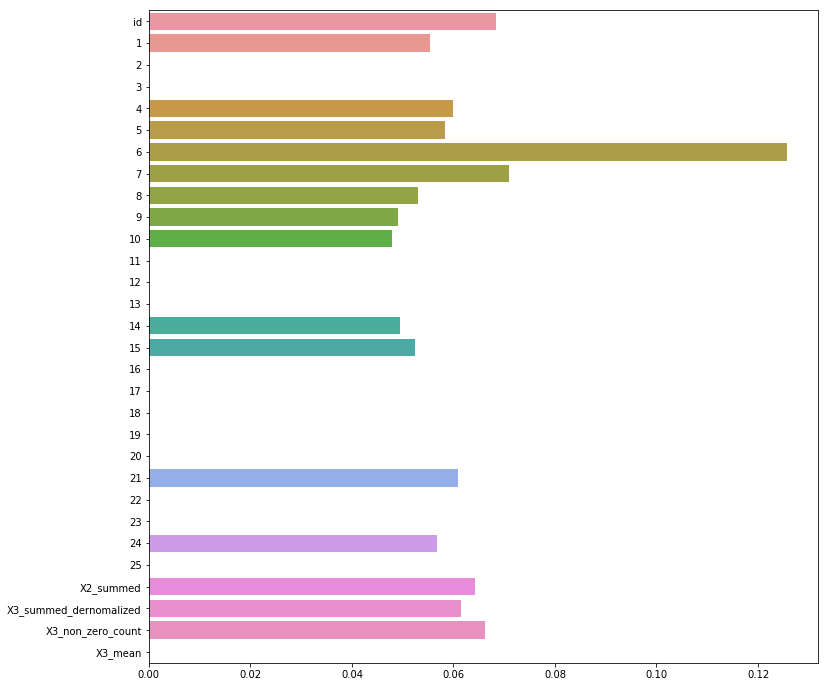

In [0]:
xgb_cls = xgb.XGBClassifier(n_jobs=8, random_state=0, **xgb_params)

xgb_cls.fit(X_train.values, Y['1'])

plt.figure(figsize=(12,12))
sns.barplot(x=xgb_cls.feature_importances_,y=X_train.columns)

In [0]:
from sklearn.feature_selection import SelectFromModel

y_train=Y['1']

selection = SelectFromModel(xgb_cls, threshold=0.01, prefit=False)
select_X_train = selection.fit_transform(X_train, y_train)

print(validate(xgb_cls, select_X_train, y_train, random_state=None, n_folds=5).mean())

 40%|████      | 2/5 [00:00<00:00,  8.03it/s]

0.5884782608695653
0.6191952617668807


 80%|████████  | 4/5 [00:00<00:00,  7.96it/s]

0.5822388293468775
0.60090251533698


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]

0.611095212937689
0.6003820160515985


In [0]:
select_X_train.shape, X_train.shape

((4000, 16), (4000, 30))

In [0]:
print(validate(xgb_cls, X_train.values, y_train, random_state=None, n_folds=5).mean())

 40%|████      | 2/5 [00:00<00:00,  5.81it/s]

0.5802898550724638
0.6182471758754237


 80%|████████  | 4/5 [00:00<00:00,  5.65it/s]

0.5873030079281618
0.6044287562052446


100%|██████████| 5/5 [00:00<00:00,  5.68it/s]

0.6090626926124857
0.599866297538756


In [0]:
X2_tranformed.shape

(4000, 151)

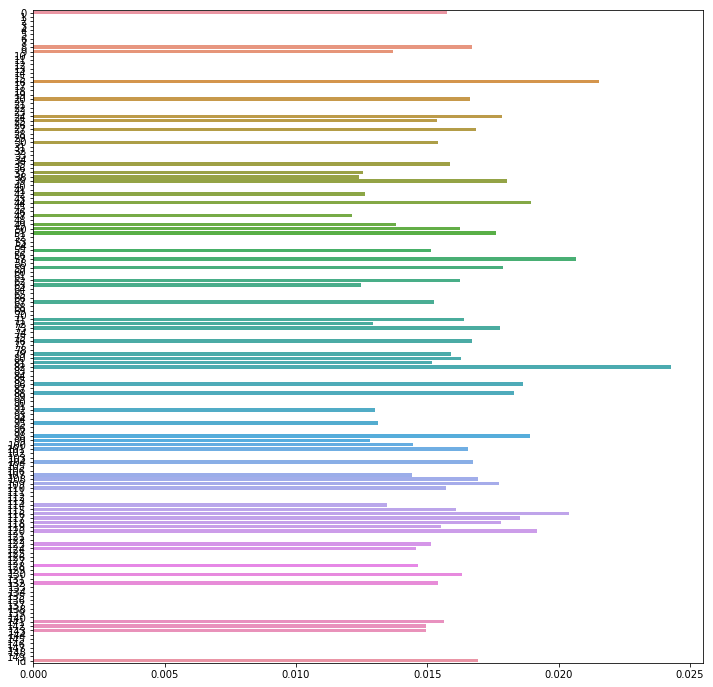

In [0]:
xgb_cls = xgb.XGBClassifier(n_jobs=8, random_state=0, **xgb_params)

xgb_cls.fit(X2_tranformed.values, Y['1'])

plt.figure(figsize=(12,12))
sns.barplot(x=xgb_cls.feature_importances_,y=X2_tranformed.columns)

In [0]:
y_train=Y['1']

selection = SelectFromModel(xgb_cls, threshold=0.01, prefit=False)
select_X_train = selection.fit_transform(X2_tranformed, y_train)

print(validate(xgb_cls, X2_tranformed.values, y_train, random_state=None, n_folds=5).mean())
print(validate(xgb_cls, select_X_train, y_train, random_state=None, n_folds=5).mean())

 20%|██        | 1/5 [00:00<00:02,  1.70it/s]

0.4951334858886346


 40%|████      | 2/5 [00:01<00:01,  1.69it/s]

0.5106632208564255


 60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

0.5109972478911686


 80%|████████  | 4/5 [00:02<00:00,  1.67it/s]

0.4839151389902523


  0%|          | 0/5 [00:00<?, ?it/s]

0.5168068151800651
0.5035031817613091


 20%|██        | 1/5 [00:00<00:01,  2.94it/s]

0.5340541571319604


 40%|████      | 2/5 [00:00<00:00,  3.05it/s]

0.5261949908851974


 60%|██████    | 3/5 [00:00<00:00,  3.12it/s]

0.5212859582783285


 80%|████████  | 4/5 [00:01<00:00,  3.13it/s]

0.5536920753517209


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

0.5381079216929353
0.5346670206680285


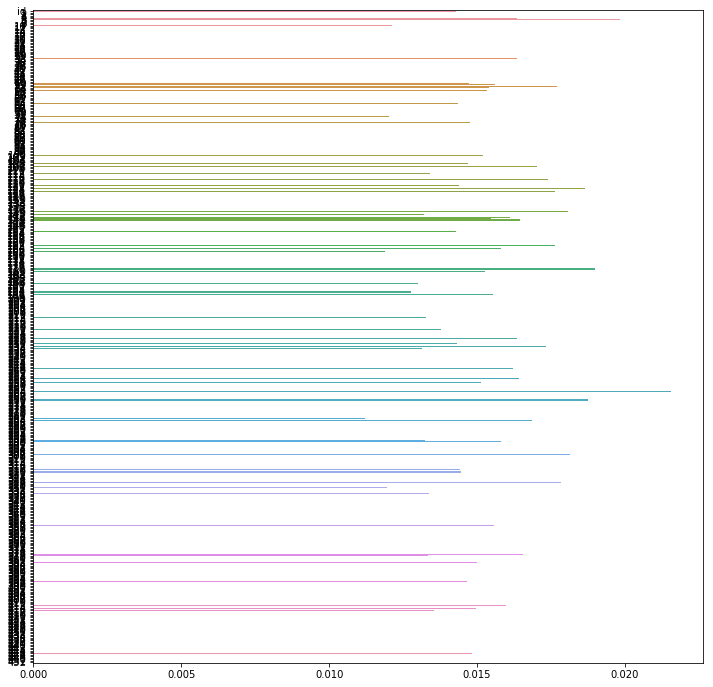

In [0]:
xgb_cls = xgb.XGBClassifier(n_jobs=8, random_state=0, **xgb_params)

xgb_cls.fit(X3.values, Y['1'])

plt.figure(figsize=(12,12))
sns.barplot(x=xgb_cls.feature_importances_,y=X3.columns)

In [0]:
y_train=Y['1']

selection = SelectFromModel(xgb_cls, threshold=0.01, prefit=False)
select_X_train = selection.fit_transform(X3, y_train)

print(validate(xgb_cls, X3.values, y_train, random_state=None, n_folds=5).mean())
print(validate(xgb_cls, select_X_train, y_train, random_state=None, n_folds=5).mean())

 20%|██        | 1/5 [00:00<00:03,  1.01it/s]

0.5209877955758964


 40%|████      | 2/5 [00:01<00:02,  1.01it/s]

0.4848562496797007


 60%|██████    | 3/5 [00:02<00:01,  1.01it/s]

0.5368961582350703


 80%|████████  | 4/5 [00:03<00:00,  1.01it/s]

0.5206949873907986


  0%|          | 0/5 [00:00<?, ?it/s]

0.49943500337530455
0.5125740388513541


 20%|██        | 1/5 [00:00<00:00,  4.18it/s]

0.5444279176201373


 40%|████      | 2/5 [00:00<00:00,  4.26it/s]

0.5298189485398013


 60%|██████    | 3/5 [00:00<00:00,  4.31it/s]

0.5836298003415896


 80%|████████  | 4/5 [00:00<00:00,  4.36it/s]

0.558031230354575


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

0.5664311291127352
0.5564678051937677
